In [7]:
import pandas as pd
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import json

- określać która dana jest typu bool czyli key, author_code
- obsłużyć 'autor_code', "release_date", 'genres'

In [8]:
TIME_LIMIT = 3600000

In [ ]:
df = pd.DataFrame()

In [9]:
def jsonl2df(path):
    with open(path) as fh:
        lines = fh.read().splitlines()

    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']


    df_inter['json_element'].apply(json.loads)

    return pd.json_normalize(df_inter['json_element'].apply(json.loads))

artists = jsonl2df("datav2/artists.jsonl")
tracks = jsonl2df("datav2/tracks.jsonl")

In [27]:
result = ['ranking', 'list', ...]

tracks[tracks['id'].isin(result)]

,id,name,popularity,duration_ms,explicit,id_artist,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo


In [10]:
# Join tracks with artists
prepared_data = pd.merge(tracks,artists, left_on="id_artist", right_on="id")

# Remove rows with empty values
prepared_data = prepared_data.dropna()
prepared_data = prepared_data.drop(columns=["name_x", "popularity", "id_y", "name_y"])

# Convert dates to number of days from earliest track
prepared_data["release_date"] = pd.to_datetime(prepared_data["release_date"], format = "mixed")
min_date = prepared_data['release_date'].min()
prepared_data['release_date'] = (prepared_data['release_date'] - min_date).dt.days

# Scale the attributes to [0, 1]
without = ['id_x', 'duration_ms', 'id_artists', 'genres', 'id_artist']
scaled_columns = list(set(prepared_data.columns).difference(without))
prepared_data[scaled_columns] = MinMaxScaler().fit_transform(prepared_data[scaled_columns])

# Onehot-encoding of genres
genres = pd.get_dummies(prepared_data['genres'].apply(pd.Series).stack()).groupby(level=0).sum()
prepared_data = pd.concat([prepared_data, genres], axis=1)

# Onehot-encoding of artists
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(prepared_data[['id_artist']])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['id_artist']))
prepared_data = pd.concat([prepared_data, encoded_df], axis=1)

prepared_data = prepared_data.drop(columns=['id_artist', 'genres'])

In [11]:
def check_less(data, min_duration):
    for group in data['group'].unique():
        group_data = data[data['group'] == group]
        if group_data['duration_ms'].sum() < min_duration:
            print('less')
    return data

In [12]:
def merge_clusters(data, min_duration=TIME_LIMIT):
    params = data.drop(columns=['duration_ms', 'id_x'])
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(params)
    # clustering = AgglomerativeClustering(n_clusters=10).fit(params)
    data.loc[:, 'group'] = clustering.labels_

    linkage_matrix = linkage(data.drop(columns=['id_x']), method='ward')
    n_samples = data.shape[0]
    cluster_map = {i: i for i in range(n_samples)}  # Mapa dla połączeń klastrów

    for i in range(linkage_matrix.shape[0]):
        cluster_1 = int(linkage_matrix[i, 0])
        cluster_2 = int(linkage_matrix[i, 1])

        mapped_cluster_1 = cluster_map.get(cluster_1, cluster_1)
        mapped_cluster_2 = cluster_map.get(cluster_2, cluster_2)

        sum_duration_1 = data.loc[data['group'] == mapped_cluster_1, 'duration_ms'].sum()
        sum_duration_2 = data.loc[data['group'] == mapped_cluster_2, 'duration_ms'].sum()

        if sum_duration_1 < min_duration or sum_duration_2 < min_duration:
            new_cluster = max(cluster_map.values()) + 1
            cluster_map[cluster_1] = new_cluster
            cluster_map[cluster_2] = new_cluster
            data.loc[data['group'] == mapped_cluster_1, 'group'] = new_cluster
            data.loc[data['group'] == mapped_cluster_2, 'group'] = new_cluster
            cluster_map[mapped_cluster_1] = new_cluster
            cluster_map[mapped_cluster_2] = new_cluster

    return data

In [13]:
# Dataframe (id, group)
def advanced_model(data):
    data = merge_clusters(data)

    less_hour = []
    for group in data['group'].unique():
        if data[data['group'] == group]['duration_ms'].sum() < TIME_LIMIT:
            less_hour.append(group)

    result = []
    for index, row in data.iterrows():
        if row['group'] not in less_hour:
            result.append((row['id_x'], row['group']))

    result_df = pd.DataFrame(result, columns=['id', 'group'])
    return result_df

In [14]:
x = advanced_model(prepared_data[:4000])

/tmp/ipykernel_20443/2925611631.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'group'] = clustering.labels_


In [15]:
x

,id,group
0,0RNxWy0PC3AyH4ThH3aGK6,7747
1,2W889aLIKxULEefrleFBFI,7820
2,4Pnzw1nLOpDNV6MKI5ueIR,7736
3,7GLmfKOe5BfOXk7334DoKt,7728
4,6kD1SNGPkfX9LwaGd1FG92,7550
...,...,...
3925,0gsl92EMIScPGV1AU35nuD,7692
3926,0Uqs7ilt5kGX9NzFDWTBrP,7528
3927,2PdIo7ewQPuAsP99LVg9uy,7518
3928,36AWdhZIGLUTkWpJDhe7va,7692


In [16]:
x.groupby('group').count()

,id
group,
7208,13
7277,14
7326,13
7344,18
7361,16
...,...
7876,45
7881,35
7890,33


Zamiast ponownego liczenia klastrów zrobić to na podstawie utworzonych może

In [17]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [18]:
test = prepared_data.drop(columns=['id_x'])

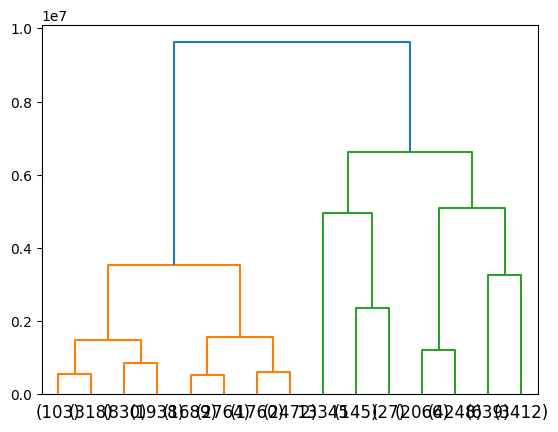

In [19]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(test)

plot_dendrogram(clustering, truncate_mode="level", p=3)

In [20]:
from sklearn.decomposition import PCA

def pca_scatter(model, labels):
    # Redukcja wymiarów za pomocą PCA do wizualizacji
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(model)

    # Wizualizacja klastrów
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.title('KMeans Clustering with PCA')
    plt.show()

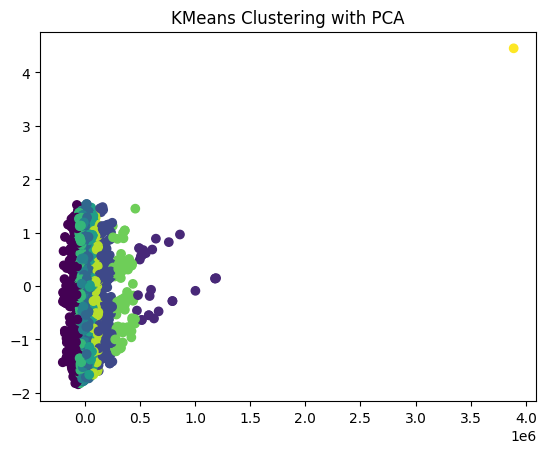

In [21]:
clustering = AgglomerativeClustering(n_clusters=10).fit(test)
labels = clustering.labels_

pca_scatter(test, labels)